<a href="https://colab.research.google.com/github/AnamarijaKozina/Duboko-ucenje-FER/blob/main/ksvm_wrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
import random

In [14]:
class Random2DGaussian:
  """Random bivariate normal distribution sampler

  Hardwired parameters:
      d0min,d0max: horizontal range for the mean
      d1min,d1max: vertical range for the mean
      scalecov: controls the covariance range 

  Methods:
      __init__: creates a new distribution

      get_sample(n): samples n datapoints

  """

  d0min=0 
  d0max=10
  d1min=0 
  d1max=10
  scalecov=5
  
  def __init__(self):
    dw0,dw1 = self.d0max-self.d0min, self.d1max-self.d1min
    mean = (self.d0min,self.d1min)
    mean += np.random.random_sample(2)*(dw0, dw1)
    eigvals = np.random.random_sample(2)
    eigvals *= (dw0/self.scalecov, dw1/self.scalecov)
    eigvals **= 2
    theta = np.random.random_sample()*np.pi*2
    R = [[np.cos(theta), -np.sin(theta)], 
         [np.sin(theta), np.cos(theta)]]
    Sigma = np.dot(np.dot(np.transpose(R), np.diag(eigvals)), R)
    self.get_sample = lambda n: np.random.multivariate_normal(mean,Sigma,n)

  
def graph_surface(function, model, rect, offset=0.5, width=256, height=256):
  """Creates a surface plot (visualize with plt.show)

  Arguments:
    function: surface to be plotted
    rect:     function domain provided as:
              ([x_min,y_min], [x_max,y_max])
    offset:   the level plotted as a contour plot

  Returns:
    None
  """

  lsw = np.linspace(rect[0][1], rect[1][1], width) 
  lsh = np.linspace(rect[0][0], rect[1][0], height)
  xx0,xx1 = np.meshgrid(lsh, lsw)
  grid = np.stack((xx0.flatten(),xx1.flatten()), axis=1)
  

  #get the values and reshape them
  values=function(model,grid).reshape((width,height))
  
  # fix the range and offset
  delta = offset if offset else 0
  maxval=max(np.max(values)-delta, - (np.min(values)-delta))
  
  # draw the surface and the offset
  plt.pcolormesh(xx0, xx1, values, 
     vmin=delta-maxval, vmax=delta+maxval)
    
  if offset != None:
    plt.contour(xx0, xx1, values, colors='black', levels=[offset])

def graph_data(X,Y_, Y, special=[]):
  """Creates a scatter plot (visualize with plt.show)

  Arguments:
      X:       datapoints
      Y_:      groundtruth classification indices
      Y:       predicted class indices
      special: use this to emphasize some points

  Returns:
      None
  """
  # colors of the datapoint markers
  palette=([0.5,0.5,0.5], [1,1,1], [0.2,0.2,0.2])
  colors = np.tile([0.0,0.0,0.0], (Y_.shape[0],1))
  for i in range(len(palette)):
    colors[Y_==i] = palette[i]

  # sizes of the datapoint markers
  sizes = np.repeat(20, len(Y_))
  sizes[special] = 40
  
  # draw the correctly classified datapoints
  good = (Y_==Y)
  plt.scatter(X[good,0],X[good,1], c=colors[good], 
              s=sizes[good], marker='o', edgecolors='black')

  # draw the incorrectly classified datapoints
  bad = (Y_!=Y)
  plt.scatter(X[bad,0],X[bad,1], c=colors[bad], 
              s=sizes[bad], marker='s', edgecolors='black')

def class_to_onehot(Y):
  Yoh=np.zeros((len(Y),max(Y)+1))
  Yoh[range(len(Y)),Y] = 1
  return Yoh

def eval_perf_multi(Y, Y_):
  pr = []
  n = max(Y_)+1
  M = np.bincount(n * Y_ + Y, minlength=n*n).reshape(n, n)
  for i in range(n):
    tp_i = M[i,i]
    fn_i = np.sum(M[i,:]) - tp_i
    fp_i = np.sum(M[:,i]) - tp_i
    tn_i = np.sum(M) - fp_i - fn_i - tp_i
    recall_i = tp_i / (tp_i + fn_i)
    precision_i = tp_i / (tp_i + fp_i)
    pr.append( (recall_i, precision_i) )
  
  accuracy = np.trace(M)/np.sum(M)
  
  return accuracy, pr, M

def eval_AP(ranked_labels):
  """Recovers AP from ranked labels"""
  
  n = len(ranked_labels)
  pos = sum(ranked_labels)
  neg = n - pos
  
  tp = pos
  tn = 0.
  fn = 0.
  fp = neg
  
  sumprec=0
  #IPython.embed()
  for x in ranked_labels:
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)    

    if x:
      sumprec += precision
      
    #print (x, tp,tn,fp,fn, precision, recall, sumprec)
    #IPython.embed()

    tp -= x
    fn += x
    fp -= not x
    tn += not x

  return sumprec/pos

def sample_gmm_2d(ncomponents, nclasses, nsamples):
  # create the distributions and groundtruth labels
  Gs=[]
  Ys=[]
  for i in range(ncomponents):
    Gs.append(Random2DGaussian())
    Ys.append(np.random.randint(nclasses))

  # sample the dataset
  X = np.vstack([G.get_sample(nsamples) for G in Gs])
  Y_= np.hstack([[Y]*nsamples for Y in Ys])
  
  return X,Y_

In [15]:
class KSVMWrap:
  def __init__(self, X, Y_, kernel='rbf', param_svm_c=1, param_svm_gamma='auto'):
    self.model = svm.SVC(C = param_svm_c, gamma=param_svm_gamma, kernel=kernel)
    self.model.fit(X, Y_)
    self.x = X
    self.Y_ = Y_
  
  def predict(self, x):
    return self.model.predict(x)

  def get_scores(self, x):
    return self.model.decision_function(x)

  def support(self):
    return self.model.support_ #returns indices of data used as support vectors

def decizijska_funkcija(model, x):
  return model.get_scores(x)


Average precision: 0.9504628298251653


Tocnost: 0.8791666666666667
Odaziv i preciznost, redom za klase: [(0.9, 0.864), (0.8583333333333333, 0.8956521739130435)]
Matrica konfuzije:
[[108  12]
 [ 17 103]]



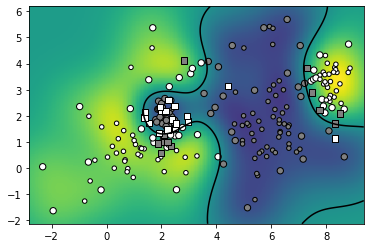

In [19]:
if __name__ == "__main__":
  np.random.seed(100)

  X, Y_ = sample_gmm_2d(6, 2, 40)
  Yoh_ = class_to_onehot(Y_)

  model = KSVMWrap(X, Y_)

  probs = model.get_scores(X)
  Y_pred = probs>0 # matrica predvidenih razreda, 0/1

  indices = np.argsort(probs[:])
  Y_ranked = Y_[indices]
  print(f"\nAverage precision: {eval_AP(Y_ranked)}\n")

  accuracy, pr, M = eval_perf_multi(Y_pred, Y_)
  print(f"\nTocnost: {accuracy}\nOdaziv i preciznost, redom za klase: {pr}\nMatrica konfuzije:\n{M}\n")
  

  # graph the decision surface
  rect = (np.min(X, axis=0) - 0.5, np.max(X, axis=0) + 0.5)

  graph_surface(decizijska_funkcija, model, rect, offset=0)

  # graph the data points
  graph_data(X, Y_, Y_pred, special=model.support())

  plt.show()